In [1]:
import main
import os

import numpy as np

image array:
 [[197 197 197 ... 197 197 197]
 [197 197 197 ... 197 197 197]
 [197 197 197 ... 197 197 197]
 ...
 [197 197 197 ... 197 197 197]
 [197 197 197 ... 197 197 197]
 [197 197 197 ... 197 197 197]]
num images loaded: 10


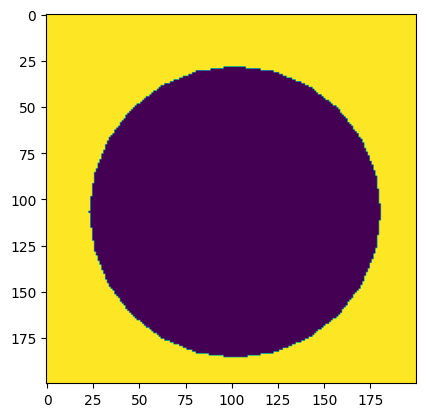

In [2]:
base_path = os.getcwd()

img_path = os.path.join(base_path, "data", "geometric shapes dataset", "Circle", "Circle_0a0b51ca-2a86-11ea-8123-8363a7ec19e6.png")

# cv2.imread does not work on linux, im using matlab for visualization
img_BGR = main.load_img(img_path, greyscale=False)
img = main.load_img(img_path)
print("image array:\n", img)
main.plt.imshow(img)

folder_path = os.path.join(base_path, 'data', 'geometric shapes dataset', 'Square')
data = main.load_img_from_folder(folder_path)
print("num images loaded:", len(data))


image shape: (200, 200)
lines detected:
[]


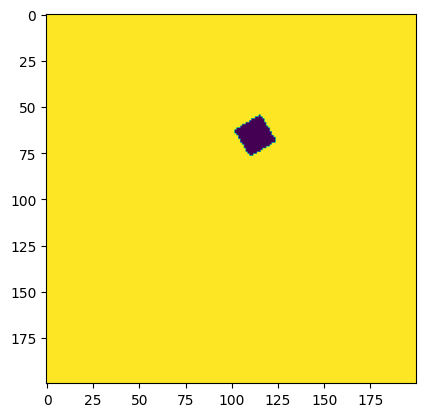

In [3]:
img = data[0]
print("image shape:", img.shape)
main.plt.imshow(img)
lines = main.detect_line(img, canny_thres1=10, 
             canny_thres2=150, 
             rho=1, 
             theta=main.np.pi/180, 
             hough_thres=80, 
             min_line_len=30, 
             max_line_gap=10)
print("lines detected:")
print(lines)

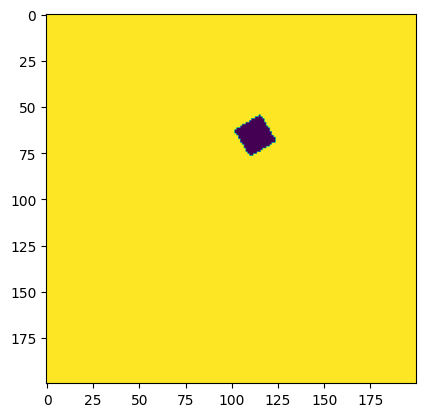

In [4]:
out = main.draw_lines(img, lines)
main.plt.imshow(out)

**Test Edge Detection on Shapes**

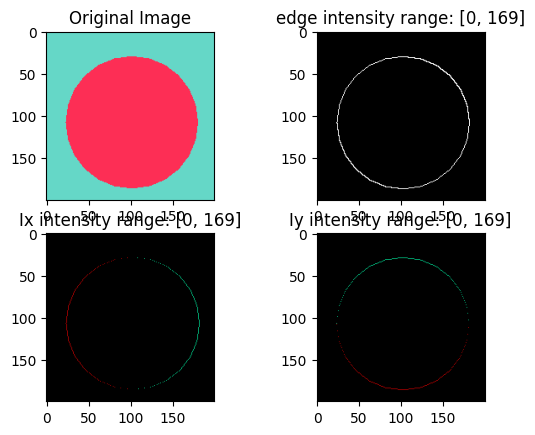

In [5]:
edges, Ix, Iy = main.detect_edges(img_BGR)

def show_edge_results(img, edges, Ix, Iy):

    def get_minmax(img):
        min = np.min(img)
        max = np.max(img)
        return min, max

    fig, ax = main.plt.subplots(2,2)
    ax[0,0].title.set_text("Original Image")
    ax[0,0].imshow(img)

    min, max = get_minmax(edges)
    ax[0,1].title.set_text(f"edge intensity range: [{min}, {max}]")
    ax[0,1].imshow(edges, cmap='gray', vmin=min, vmax=max)

    min, max = get_minmax(Ix)
    ax[1,0].title.set_text(f"Ix intensity range: [{min}, {max}]")
    ax[1,0].imshow(Ix, vmin=min, vmax=max)

    min, max = get_minmax(Iy)
    ax[1,1].title.set_text(f"Iy intensity range: [{min}, {max}]")
    ax[1,1].imshow(Iy, vmin=min, vmax=max)

show_edge_results(img_BGR, edges, Ix, Iy)

**Test Edge Detection on Physical Parts**

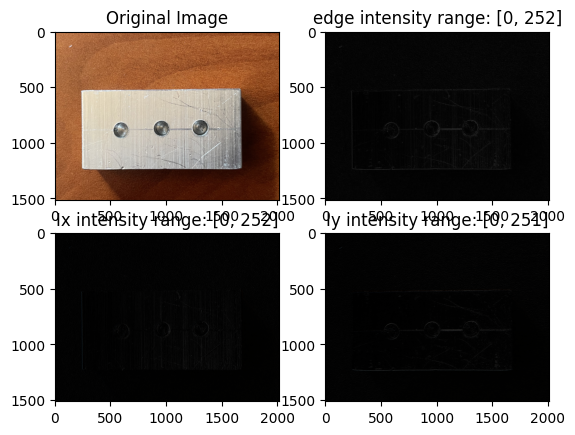

In [ ]:
img_path = os.path.join(base_path, "data", "physical parts", "Basic II base part.jpg")

img_part1 = main.load_img(img_path, greyscale=False)
# crop img
H,W = img_part1.shape[0:2]
Z = 4   # zoom factor
Zh = Z//2
img_part1 = img_part1[H*(Zh-1)//Z : H*(Zh+1)//Z , W*(Zh-1)//Z : W*(Zh+1)//Z]
# convert to RGB
img_part1 = main.cv2.cvtColor(img_part1, main.cv2.COLOR_BGR2RGB)

edges, Ix, Iy = main.detect_edges(img_part1)

show_edge_results(img_part1, edges, Ix, Iy)